# Smith-waterman algorithm parallel implementation using the [wozniak](https://academic.oup.com/bioinformatics/article/13/2/145/248735?login=false) method

First we have to install pycuda

In [ ]:
!pip install pycuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 KB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pycuda: filename=pycuda-2022.2.2-cp38-cp38-linux_x86_64.whl size=646530 sha256=cd913e9b420810e8fe49c2e390eb1ae8888783b224d5017c1f63011279a45c71
  Stored in directory: /root/.cache/pip/wheels/7b/41/0d/7cecb04af969d283ebe4a69579a8b2baec0d010a1ac4159f7e
  Created wheel for pytools: filename=pytools-2022.1.14-py2.py3-none-any.whl size=69870 sha256=9cb04b7686121bba298398bee00abd5d933c88e148d331f5122151118b3abe40
  Stored in directory: /root/.cache/pip/wheels/cb/fc/

We get the instance of gpu here

In [ ]:
!nvidia-smi

Tue Jan 10 13:57:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Import numpy so we can work with arrays.

In [ ]:
import numpy as np

This is a basic idea for sequential calculation of the matrix.

A and B correspond to our string sequences we just encode them as numbers alphabetically.

For each cell this is how we calculate its value.
The first row and column are filled with zeros.

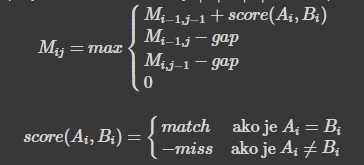

This is what sequentiall filling would look like.

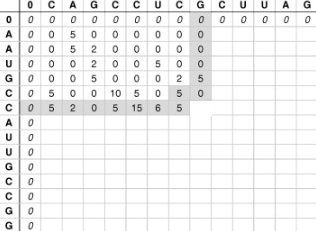

In [ ]:
%%time

asize = 11

matrica = np.zeros((11,11)).astype(dtype=np.int32)
matrica = np.round(matrica,1)

match = 5
miss = 3
gap = 9

a = np.array([0,3,1,7,3,3,21,3,7,3,21,21,1,7])
b = np.array([0,1,1,21,7,3,3,1,21,21,7,3,3,7,7])

for i in range(0,asize):
  for j in  range(0,asize):
    if i == 0 or j == 0:
      continue
    score = 0
    if (a[j] == b[i]):
      score = match 
    else:
      score = -miss
    
    res1 = matrica[i][j-1] - gap
    res2 = matrica[i-1][j-1] + score
    res3 = matrica[i-1][j] - gap

    max_res = 0
    if res1 > max_res or res2 > max_res:
      if res1 >= res2:
        max_res = res1
      else:
        max_res = res2

    if max_res < res3:
      max_res = res3

    matrica[i][j] = max_res

print(matrica)

[[ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  0  0  0  0]
 [ 0  0  5  2  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  5  0  0  0  5]
 [ 0  0  0  5  0  0  0  2  5  0  0]
 [ 0  5  0  0 10  5  0  5  0 10  1]
 [ 0  5  2  0  5 15  6  5  2  5  7]
 [ 0  0 10  1  0  6 12  3  2  0  2]
 [ 0  0  1  7  0  0 11  9  0  0  5]
 [ 0  0  0  0  4  0  5  8  6  0  5]
 [ 0  0  0  5  0  1  0  2 13  4  0]]
CPU times: user 1.85 ms, sys: 1.12 ms, total: 2.96 ms
Wall time: 2.97 ms


# 1. Cuda parallel implementation of the Smith-waterman algorithm


The implementation calculates the numbers on the diagonal parallel and the diagonals themselves are calculated sequentially (when diagonal 1. is calculated we move to diagonal 2.)

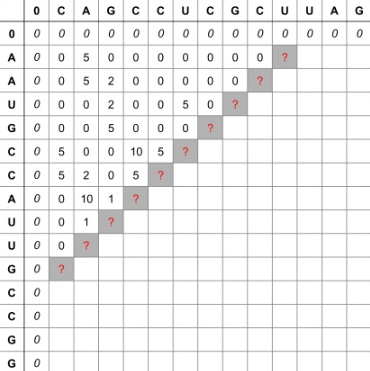

In [ ]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

mod = SourceModule("""
      //int match, int miss, int gap,
      __global__ void smith_waterman(int match, int miss, int gap, int *matrica, int *A, int *B, int asize, int bsize, int diagonal)
      {
        int ma = 0;
        if (asize >= bsize)
        {
          ma = asize;
        }
        else
        {
          ma = bsize;
        }

        if ((threadIdx.x == 0 || threadIdx.y == 0) || ((threadIdx.x + threadIdx.y) != diagonal) || (threadIdx.x >= ma || threadIdx.y >= ma))
        {
          return;
        }

        int idx = threadIdx.x + threadIdx.y*asize;

        int idx1 = threadIdx.x-1 + threadIdx.y*asize;
        int idx2 = threadIdx.x-1 + (threadIdx.y-1)*asize;
        int idx3 = threadIdx.x + (threadIdx.y-1)*asize;

        int score = 0;
        if (A[threadIdx.x*2] == B[threadIdx.y*2])
        {
          score = match;
        }
        else
        {
          score = -miss;
        }

        int res1c = matrica[idx1] - gap;
        int res2 = matrica[idx2] + score;
        int res3 = matrica[idx3] - gap;

        int max_res = 0;
        if (res1 > max_res || res2 > max_res)
        {
          if (res1 >= res2)
          {
            max_res = res1;
          }
          else
          {
            max_res = res2;
          }
        }
        
        if (max_res < res3)
        {
          max_res = res3;
        }

        matrica[idx] = max_res;
        __syncthreads();
      }
   """)

In [ ]:
asize = 10
bsize = 10

matrica = np.zeros((10,10)).astype(dtype=np.int32)
matrica = np.round(matrica,1)

a = np.array([0,3,1,7,3,3,21,3,7,3,21,21,1,7,0])
b = np.array([0,1,1,21,7,3,3,1,21,21,7,3,3,7,7])

matrica_gpu = cuda.mem_alloc(matrica.nbytes)
a_gpu = cuda.mem_alloc(a.nbytes)
b_gpu = cuda.mem_alloc(b.nbytes)

cuda.memcpy_htod(matrica_gpu, matrica)
cuda.memcpy_htod(a_gpu, a)
cuda.memcpy_htod(b_gpu, b)

match = 5
miss = 3
gap = 9

func = mod.get_function("smith_waterman")


In [ ]:
%%time
for i in range(0,asize*2):
  func(np.int32(match), np.int32(miss), np.int32(gap), matrica_gpu, a_gpu, b_gpu, np.int32(asize), np.int32(bsize), np.int32(i), block=(10,10,1), grid=(1,1,1))

CPU times: user 617 µs, sys: 0 ns, total: 617 µs
Wall time: 623 µs


In [ ]:
cuda.memcpy_dtoh(matrica, matrica_gpu)

print("Result: \n", matrica)

Result: 
 [[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  0  0  0]
 [ 0  0  5  2  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  5  0  0  0]
 [ 0  0  0  5  0  0  0  2  5  0]
 [ 0  5  0  0 10  5  0  5  0 10]
 [ 0  5  2  0  5 15  6  5  2  5]
 [ 0  0 10  1  0  6 12  3  2  0]
 [ 0  0  1  7  0  0 11  9  0  0]
 [ 0  0  0  0  4  0  5  8  6  0]]


# 2.Cuda parallel reduction to find the maximum value in the previously calculated matrix

We do reduction of each row (we find the maximum value in that row and write it as the first element in data since its already 0 and not in use. And then we do the same for the first column since it contains the maximum values of the rows.

Data is first draged into the shared "data" memory since access to it is faster.

In [ ]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

mod = SourceModule("""
     __global__ void reduce(int *matrica, int asize){
     
        __shared__ int data[1024];
        int idx = threadIdx.x + threadIdx.y*asize;

        data[idx] = matrica[idx];
        __syncthreads();

        //calculating max for rows
        for(unsigned int s=1; s < blockDim.x; s *= 2) { 
        
          if (threadIdx.x % (2*s) == 0 && threadIdx.x+s < blockDim.x){
            if (data[idx] < data[idx + s])
            {
              data[idx] = data[idx + s]; 
            }
          }   
          __syncthreads(); 
        }

        //calculating max for column x == 0
        for(unsigned int s=1; s < blockDim.y; s *= 2) { 
        
          if (threadIdx.x == 0 && threadIdx.y % (2*s) == 0 && threadIdx.y+s < blockDim.y){
            if (data[idx] < data[idx + s*asize])
            {
              data[idx] = data[idx + s*asize]; 
            }
          }   
          __syncthreads(); 
        }

        if (threadIdx.x == 0 and threadIdx.y == 0)
        {
          matrica[0] = data[0];
        }
    }
   """)

In [ ]:
cuda_reduce = mod.get_function("reduce")

cuda_reduce(matrica_gpu, np.int32(asize), block=(10,10,1), grid=(1,1,1))

cuda.memcpy_dtoh(matrica, matrica_gpu)

print("Matrix max is: \n", matrica[0][0])

#deleting the result of max from matrix and saving it in res
res = matrica[0][0]
matrica[0][0] = 0
cuda.memcpy_htod(matrica_gpu, matrica)

Matrix max is: 
 15


Modification of the 1. with constant memory. Access to constant memory is faster and we store data which we dont modify during the kernel call.

In [ ]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

mod = SourceModule("""
      __constant__  int A[11];
      __constant__  int B[11];

      __global__ void smith_waterman_constant(int match, int miss, int gap, int *matrica, int asize, int bsize, int diagonal)
      {
        int ma = 0;
        if (asize >= bsize)
        {
          ma = asize;
        }
        else
        {
          ma = bsize;
        }

        if ((threadIdx.x == 0 || threadIdx.y == 0) || ((threadIdx.x + threadIdx.y) != diagonal) || (threadIdx.x >= ma || threadIdx.y >= ma))
        {
          return;
        }

        int idx = threadIdx.x + threadIdx.y*asize;

        int idx1 = threadIdx.x-1 + threadIdx.y*asize;
        int idx2 = threadIdx.x-1 + (threadIdx.y-1)*asize;
        int idx3 = threadIdx.x + (threadIdx.y-1)*asize;

        int score = 0;
        if (A[threadIdx.x*2] == B[threadIdx.y*2])
        {
          score = match;
        }
        else
        {
          score = -miss;
        }

        int res1 = matrica[idx1] - gap;
        int res2 = matrica[idx2] + score;
        int res3 = matrica[idx3] - gap;

        int max_res = 0;
        if (res1 > max_res || res2 > max_res)
        {
          if (res1 >= res2)
          {
            max_res = res1;
          }
          else
          {
            max_res = res2;
          }
        }
        
        if (max_res < res3)
        {
          max_res = res3;
        }

        matrica[idx] = max_res;
        __syncthreads();
      }
   """)

In [ ]:
asize = 10
bsize = 10

func = mod.get_function("smith_waterman_constant")

matrica = np.zeros((10,10)).astype(dtype=np.int32)
matrica = np.round(matrica,1)

a = np.array([0,3,1,7,3,3,21,3,7,3,21,21,1,7,0])
b = np.array([0,1,1,21,7,3,3,1,21,21,7,3,3,7,7])

a_cuda = mod.get_global('A')
b_cuda = mod.get_global('B')

cuda.memcpy_htod(matrica_gpu, matrica)
cuda.memcpy_htod(a_cuda[0], a)
cuda.memcpy_htod(b_cuda[0], b)

match = 5
miss = 3
gap = 9

for i in range(0,asize*2):
  func(np.int32(match), np.int32(miss), np.int32(gap), matrica_gpu, np.int32(asize), np.int32(bsize), np.int32(i), block=(10,10,1), grid=(1,1,1))

cuda.memcpy_dtoh(matrica, matrica_gpu)

print("Result: \n", matrica)

Modification of 1. so it uses shared memory for the matrix.

In [ ]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

mod = SourceModule("""
      //int match, int miss, int gap,
      __global__ void smith_waterman(int match, int miss, int gap, int *matrica, int *A, int *B, int asize, int bsize, int diagonal)
      {
        int ma = 0;
        if (asize >= bsize)
        {
          ma = asize;
        }
        else
        {
          ma = bsize;
        }

        int idx = threadIdx.x + threadIdx.y*asize;

        __shared__ int share[1024];

        share[idx] = matrica[idx];
        __syncthreads();

        if ((threadIdx.x == 0 || threadIdx.y == 0) || ((threadIdx.x + threadIdx.y) != diagonal) || (threadIdx.x >= ma || threadIdx.y >= ma))
        {
          return;
        } 

        int idx1 = threadIdx.x-1 + threadIdx.y*asize;
        int idx2 = threadIdx.x-1 + (threadIdx.y-1)*asize;
        int idx3 = threadIdx.x + (threadIdx.y-1)*asize;

        int score = 0;
        if (A[threadIdx.x*2] == B[threadIdx.y*2])
        {
          score = match;
        }
        else
        {
          score = -miss;
        }

        int res1 = share[idx1] - gap;
        int res2 = share[idx2] + score;
        int res3 = share[idx3] - gap;

        int max_res = 0;
        if (res1 > max_res || res2 > max_res)
        {
          if (res1 >= res2)
          {
            max_res = res1;
          }
          else
          {
            max_res = res2;
          }
        }
        
        if (max_res < res3)
        {
          max_res = res3;
        }

        matrica[idx] = max_res;
        __syncthreads();
      }
   """)

In [ ]:
asize = 10
bsize = 10

matrica = np.zeros((10,10)).astype(dtype=np.int32)

a = np.array([0,3,1,7,3,3,21,3,7,3,21,21,1,7,0])
b = np.array([0,1,1,21,7,3,3,1,21,21,7,3,3,7,7])

matrica_gpu = cuda.mem_alloc(matrica.nbytes)
a_gpu = cuda.mem_alloc(a.nbytes)
b_gpu = cuda.mem_alloc(b.nbytes)

cuda.memcpy_htod(matrica_gpu, matrica)
cuda.memcpy_htod(a_gpu, a)
cuda.memcpy_htod(b_gpu, b)

match = 5
miss = 3
gap = 9

func = mod.get_function("smith_waterman")

for i in range(0,asize*2):
  func(np.int32(match), np.int32(miss), np.int32(gap), matrica_gpu, a_gpu, b_gpu, np.int32(asize), np.int32(bsize), np.int32(i), block=(10,10,1), grid=(1,1,1))

cuda.memcpy_dtoh(matrica, matrica_gpu)

print("Result: \n", matrica)

# 3. Modifying the code from 1. so it can run on bigger matrixes by implementing blocks. Blocks in cuda hold threads, and gpus have limits on how many threads a block can hold but not how many blocks a gpu can have. 

Our previous logic:

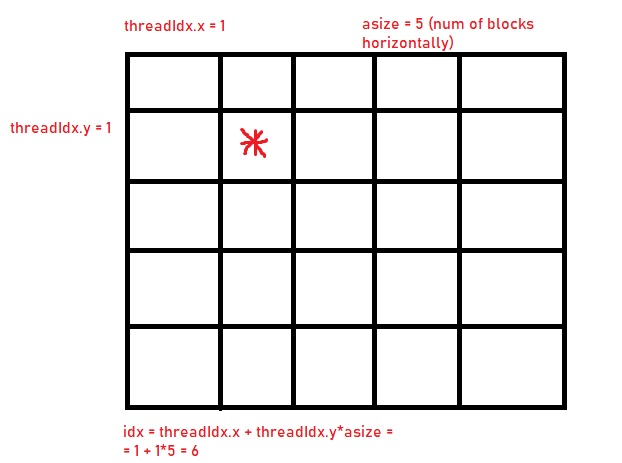

Our new logic:

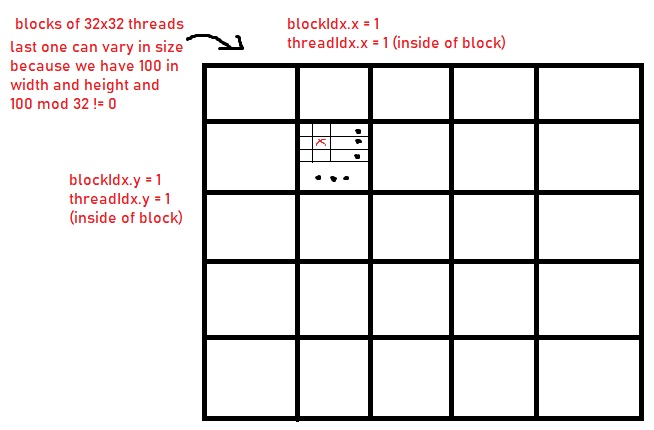

In [ ]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

mod = SourceModule("""
      __global__ void smith_waterman(int match, int miss, int gap, int *matrica, int *A, int *B, int asize, int bsize, int diagonal)
      {
        int ma = 0;
        if (asize >= bsize)
        {
          ma = asize;
        }
        else
        {
          ma = bsize;
        }

        if ((threadIdx.x == 0 || threadIdx.y == 0) || ((threadIdx.x + threadIdx.y) != diagonal) || (threadIdx.x >= ma || threadIdx.y >= ma))
        {
          return;
        }

        int idx = threadIdx.x + blockDim.x*blockIdx.x + threadIdx.y*asize + blockDim.y*blockIdx.y*asize;

        int idx1 = threadIdx.x-1 + blockDim.x*blockIdx.x + threadIdx.y*asize + blockDim.y*blockIdx.y*asize;
        int idx2 = threadIdx.x-1 + blockDim.x*blockIdx.x + (threadIdx.y-1)*asize + blockDim.y*blockIdx.y*asize;
        int idx3 = threadIdx.x + blockDim.x*blockIdx.x + (threadIdx.y-1)*asize + blockDim.y*blockIdx.y*asize;

        int score = 0;
        if (A[threadIdx.x*2] == B[threadIdx.y*2])
        {
          score = match;
        }
        else
        {
          score = -miss;
        }

        int res1 = matrica[idx1] - gap;
        int res2 = matrica[idx2] + score;
        int res3 = matrica[idx3] - gap;

        int max_res = 0;
        if (res1 > max_res || res2 > max_res)
        {
          if (res1 >= res2)
          {
            max_res = res1;
          }
          else
          {
            max_res = res2;
          }
        }
        
        if (max_res < res3)
        {
          max_res = res3;
        }

        matrica[idx] = max_res;
        __syncthreads();
      }
   """)

In [ ]:
import math

asize = 100
bsize = 100

matrica = np.zeros((100,100)).astype(dtype=np.int32)

a = np.array([0,3,1,7,3,3,21,3,7,3,21,21,1,7,0,0,3,1,7,3,3,21,3,7,3,21,21,1,7,0
             ,0,3,1,7,3,3,21,3,7,3,21,21,1,7,0,0,3,1,7,3,3,21,3,7,3,21,21,1,7,0
             ,0,3,1,7,3,3,21,3,7,3,21,21,1,7,0,0,3,1,7,3,3,21,3,7,3,21,21,1,7,0
             ,0,3,1,7,3,3,21,3,7,3])
b = np.array([0,1,1,21,7,3,3,1,21,21,7,3,3,7,7,0,1,1,21,7,3,3,1,21,21,7,3,3,7,7
             ,0,1,1,21,7,3,3,1,21,21,7,3,3,7,7,0,1,1,21,7,3,3,1,21,21,7,3,3,7,7
             ,0,1,1,21,7,3,3,1,21,21,7,3,3,7,7,0,1,1,21,7,3,3,1,21,21,7,3,3,7,7
             ,0,1,1,21,7,3,3,1,21,21])

matrica_gpu = cuda.mem_alloc(matrica.nbytes)
a_gpu = cuda.mem_alloc(a.nbytes)
b_gpu = cuda.mem_alloc(b.nbytes)

cuda.memcpy_htod(matrica_gpu, matrica)
cuda.memcpy_htod(a_gpu, a)
cuda.memcpy_htod(b_gpu, b)

match = 5
miss = 3
gap = 9

func = mod.get_function("smith_waterman")

for i in range(0,asize*2):
  func(np.int32(match), np.int32(miss), np.int32(gap), matrica_gpu, a_gpu, b_gpu, np.int32(asize), np.int32(bsize), np.int32(i), block=(10,10,1), grid=(math.ceil(matrica.shape[1]/32),math.ceil(matrica.shape[0]/32),1))

cuda.memcpy_dtoh(matrica, matrica_gpu)

print("Result: \n", matrica[1:10])

Result: 
 [[ 0  0  5  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  5  0
   0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  5  2  0  0  0  0  0  0  0  0  5  2  0  0  0  0  0  0  0  0  5  2
   0  0  0  0  0  0  0  0  5  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  0  2  0  0  5  0  0  0  0  0  0  2  0  0  5  0  0  0  0  0  0  2
   0  0  5  0  0  0  0  0  0  2  0  0  5  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  0  5  0  0  0  2  5  0  0  0  0  5  0  0  0  2  